In [1]:
# =============================================================================
# SECTION 1: IMPORT PACKAGES & DOWNLOAD DATA
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize FRED API (replace with your API key)
api_key = 'ada1a8ba0569ed784226f2c26db44ab1'
fred = Fred(api_key=api_key)

# Define factor blocks based on Appendix B (using only valid FRED IDs)
factor_blocks = {
    'Global': [
        'GDPC1',     # Real Gross Domestic Product
        'INDPRO',    # Industrial Production Index
        'DSPIC96',   # Real Disposable Personal Income
        'WEI',       # Weekly Economic Index
        'DGS10',     # 10-Year Treasury Yield
        'DGS2',      # 2-Year Treasury Yield
        'DCOILWTICO',# Crude Oil Price: WTI
        'SP500',     # S&P 500 Index
        'PCEC',      # Real Personal Consumption Expenditures
        'GPDI',      # Gross Private Domestic Investment
        'GDPDEF'     # GDP Price Deflator
    ],
    'Labor': [
        'PAYEMS',    # Total nonfarm payroll employment
        'JTSJOL',    # Job Openings
        'UNRATE',    # Unemployment Rate
        'ICSA',      # Initial Claims for Unemployment Insurance
        'CCSA',      # Continuing Claims for Unemployment Insurance
        'AHETPI',    # Average Hourly Earnings, Production Workers: Manufacturing (proxy for Real Wage)
        'AWHNONAG',  # Average Weekly Hours, Total Nonfarm (proxy for Hours Worked)
        'CE16OV'     # Civilian Labor Force: Employed, Total
    ],
    'Inflation': [
        'CPIAUCSL',  # CPI for All Urban Consumers
        'CPILFESL',  # CPI Less Food and Energy
        'PCEPI',     # Personal Consumption Expenditures Price Index
        'WM2NS'      # M2 Money Stock (as a proxy)
    ],
    'Housing': [
        'HOUST',     # Housing Starts
        'PERMIT',    # Building Permits
        'HSN1F',     # New Single-Family Houses Sold
        'HPIPONM226S'# Alternative Housing Starts series
    ],
    'Surveys': [
        'GACDISA066MSFRBNY',  # Empire State Manufacturing Survey: General Business Conditions
        'GACDFSA066MSFRBPHI',  # Philadelphia Fed Manufacturing Survey: Current Activity
        'UMCSENT'             # University of Michigan Consumer Sentiment
    ],
    'Financial': [
        'FEDFUNDS',  # Federal Funds Rate
        'TB3MS',     # 3-Month Treasury Bill Rate
        'TB6MS',     # 6-Month Treasury Bill Rate
        'GS1',       # 1-Year Treasury Constant Maturity Rate
        'GS5',       # 5-Year Treasury Constant Maturity Rate
        'AAA',       # Moody's Aaa Corporate Bond Yield
        'BAA',       # Moody's Baa Corporate Bond Yield
        'M1SL',      # M1 Money Stock (Seasonally Adjusted)
        'M2SL',      # M2 Money Stock (Seasonally Adjusted)
        'M3SL',      # M3 Money Stock (Seasonally Adjusted)
    ]
}

def fetch_series(series_id, start_date):
    """Fetch a single FRED series as a DataFrame."""
    s = fred.get_series(series_id, start_date)
    s = s.to_frame(name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

start_date = "2000-01-01"
raw_series_data = {}
for cat, series_list in factor_blocks.items():
    for s in series_list:
        try:
            raw_series_data[s] = fetch_series(s, start_date)
        except Exception as e:
            print(f"Series {s} not found on FRED: {e}")

Series MBASE not found on FRED: Bad Request.  The series does not exist.


In [2]:
# =============================================================================
# SECTION 2: MERGE DATA INTO A COMMON WEEKLY INDEX & STANDARDIZE
# =============================================================================
# Determine the most recent date across all raw series
max_date = max(s.index.max() for s in raw_series_data.values())

# Create a weekly index from the start date to the most recent date
weekly_index = pd.date_range("2000-01-01", max_date, freq="W-FRI")

# Create a raw merged dataset (without standardization)
raw_block_data = {}
for block, series_list in factor_blocks.items():
    df_block = pd.DataFrame(index=weekly_index)
    for s in series_list:
        if s in raw_series_data:
            df_block[s] = raw_series_data[s].reindex(weekly_index, method='nearest')
    # Fill missing values with NaN (raw data)
    raw_block_data[block] = df_block

raw_merged_data = pd.concat(list(raw_block_data.values()), axis=1)

# Now create standardized data for model estimation:
standardized_block_data = {}
for block, df in raw_block_data.items():
    # Demean and standardize each block
    df_std = (df - df.mean(skipna=True)) / df.std(skipna=True)
    df_std.fillna(0, inplace=True)
    standardized_block_data[block] = df_std

merged_data = pd.concat(list(standardized_block_data.values()), axis=1)
# Set standardized dataset for estimation
data_std = merged_data.copy()

In [3]:
# =============================================================================
# SECTION 3: IDENTIFICATION VECTOR & OBSERVED DIMENSION
# =============================================================================
N_total = data_std.shape[1]
if "GDPC1" in data_std.columns:
    idx_gdp = list(data_std.columns).index("GDPC1")
else:
    idx_gdp = None
iota = np.zeros(N_total)
if idx_gdp is not None:
    iota[idx_gdp] = 1

In [4]:
# =============================================================================
# SECTION 4: PCA INITIALIZATION
# =============================================================================
# Choose number of factors q
q = 6
X = data_std.values  # shape (T, N_total); note: standardized data is used for factor extraction
T, N = X.shape
cov_mat = np.cov(X, rowvar=False)
eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
order = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]
Lambda0 = eigenvecs[:, :q]  # shape (N_total, q)
Lambda0_inv = np.linalg.inv(Lambda0.T @ Lambda0)
F0 = X @ Lambda0 @ Lambda0_inv   # shape (T, q)
F0 = F0.T  # shape (q, T)

In [5]:
# =============================================================================
# SECTION 5: STATE-SPACE MODEL DEFINITION & ITERATIVE ESTIMATION WITH TREND AND DRIFT
# =============================================================================

class DFMStateSpaceWithTrend(MLEModel):
    def __init__(self, endog, Lambda_init, iota, F_dim, mu_g_init=0.005, **kwargs):
        """
        Constructs a state-space model for the dynamic factor model with a stochastic trend.
        
        Parameters:
         - endog: Observed data matrix (rows: time, columns: series), in standardized units.
         - Lambda_init: Initial loading matrix from PCA, shape (N, q).
         - iota: Identification vector (shape (N,)); typically one element equals 1 (for GDPC1) and others 0.
         - F_dim: Number of latent factors (q).
         - mu_g_init: Initial drift value for the trend component.
        """
        self.F_dim = F_dim
        self.iota = iota  # Identification vector for the trend (e.g. only GDPC1 gets a 1)
        self.current_Lambda = Lambda_init.copy()  # initialize current loadings
        self.mu_g_init = mu_g_init  # drift for the trend
        
        # Define the state vector dimensions:
        # g_t (trend) dimension = 1, f_t and f_{t-1} each of dimension q => total = 1 + 2*q.
        k_states = 1 + 2 * F_dim
        super().__init__(endog, k_states=k_states, k_posdef=k_states,
                         initialization="approximate_diffuse", **kwargs)
        N = self.ssm.k_endog
        q = F_dim

        # Set up the measurement equation:
        # X_t = iota * g_t + Λ * f_t + (0 * f_{t-1})
        design = np.column_stack([
            iota.reshape(-1, 1),  # Trend loadings
            Lambda_init,         # Loadings for current latent factors f_t
            np.zeros((N, q))     # No loadings on lagged factors f_{t-1}
        ])
        self.ssm['design'] = design
        self.ssm['obs_cov'] = np.eye(N)
        
        # Set up the state transition matrix:
        # For the trend: g_t = g_{t-1} + μ_g + noise; for latent factors, use a VAR(2).
        transition = np.eye(k_states)
        transition[0, 0] = 1.0  # Trend follows a random walk

        # For latent factors (f_t), assume a simple VAR(2) with coefficients:
        A1 = np.full((q,), 0.5)   # Coefficient for lag 1
        A2 = np.full((q,), 0.2)   # Coefficient for lag 2
        for i in range(q):
            transition[1 + i, 1 + i] = A1[i]
            if i + q < k_states:
                transition[1 + i, 1 + q + i] = A2[i]
        self.ssm['transition'] = np.real(transition)
        self.ssm['selection'] = np.eye(k_states)
        # Set state error covariance: assign variance 1.0 to the trend and 0.1 to latent factors
        self.ssm['state_cov'] = np.diag(np.concatenate(([1.0], [0.1] * (2 * q))))
        
        # Set the state intercept to include the drift for the trend.
        state_intercept = np.zeros(k_states)
        state_intercept[0] = self.mu_g_init   # Drift added only for the trend
        self.ssm['state_intercept'] = state_intercept
        
        self.mu = np.zeros(N)
    
    def update(self, params, **kwargs):
        # In this simplified version, we update only the measurement equation loadings.
        N = self.ssm.k_endog
        q = self.F_dim
        Lambda = params[:N*q].reshape(N, q)
        self.current_Lambda = Lambda.copy()
        design = np.column_stack([
            self.iota.reshape(-1, 1),
            Lambda,
            np.zeros((N, q))
        ])
        self.ssm['design'] = design
    
    @property
    def start_params(self):
        N = self.ssm.k_endog
        q = self.F_dim
        return self.current_Lambda.ravel()

# Instantiate the model using the standardized data
X_for_model = data_std.values  # rows: time, columns: series
model = DFMStateSpaceWithTrend(X_for_model, Lambda0, iota, F_dim=q, mu_g_init=0.005)

# Iterative refinement to update loadings:
max_iter = 50
tol = 1e-3
Lambda_old = model.current_Lambda.copy()

for iteration in range(max_iter):
    res = model.smooth(model.start_params)
    F_smoothed = res.smoothed_state  # shape: (1 + 2*q, T)
    # Extract latent factors: assume rows 1 to (1+q) are the current factors f_t.
    F_est = F_smoothed[1:1+q, :].T  # shape (T, q)
    Lambda_new = np.zeros_like(model.current_Lambda)
    for i in range(X_for_model.shape[1]):
        beta_i = np.linalg.lstsq(F_est, X_for_model[:, i], rcond=None)[0]
        Lambda_new[i, :] = beta_i
    diff = np.linalg.norm(Lambda_new - Lambda_old, ord='fro')
    print(f"Iteration {iteration}, Lambda update diff = {diff}")
    if diff < tol:
        break
    Lambda_old = Lambda_new.copy()
    model.update(Lambda_new.ravel())

final_Lambda = model.current_Lambda
print("Final estimated factor loadings (Lambda):")
print(final_Lambda)

final_res = model.smooth(model.start_params)
smoothed_states = final_res.smoothed_state  # shape: (1 + 2*q, T)
trend_est = smoothed_states[0, :]          # Estimated trend component, shape (T,)
F_final = smoothed_states[1:1+q, :]          # Estimated latent cyclical factors, shape (q, T)


Iteration 0, Lambda update diff = 0.23741853101042973
Iteration 1, Lambda update diff = 0.19305458193346936
Iteration 2, Lambda update diff = 0.1873955508497579
Iteration 3, Lambda update diff = 0.18422469166667296
Iteration 4, Lambda update diff = 0.1812677624222479
Iteration 5, Lambda update diff = 0.1781794358919381
Iteration 6, Lambda update diff = 0.17496894586793896
Iteration 7, Lambda update diff = 0.17171620623074327
Iteration 8, Lambda update diff = 0.16849726368252207
Iteration 9, Lambda update diff = 0.165366508998784
Iteration 10, Lambda update diff = 0.162356712829801
Iteration 11, Lambda update diff = 0.15948393822833537
Iteration 12, Lambda update diff = 0.15675282339578003
Iteration 13, Lambda update diff = 0.1541608668034822
Iteration 14, Lambda update diff = 0.15170151133719126
Iteration 15, Lambda update diff = 0.14936620668857498
Iteration 16, Lambda update diff = 0.14714570921325207
Iteration 17, Lambda update diff = 0.1450308524097832
Iteration 18, Lambda update d

State-space forecast obtained via get_forecast().


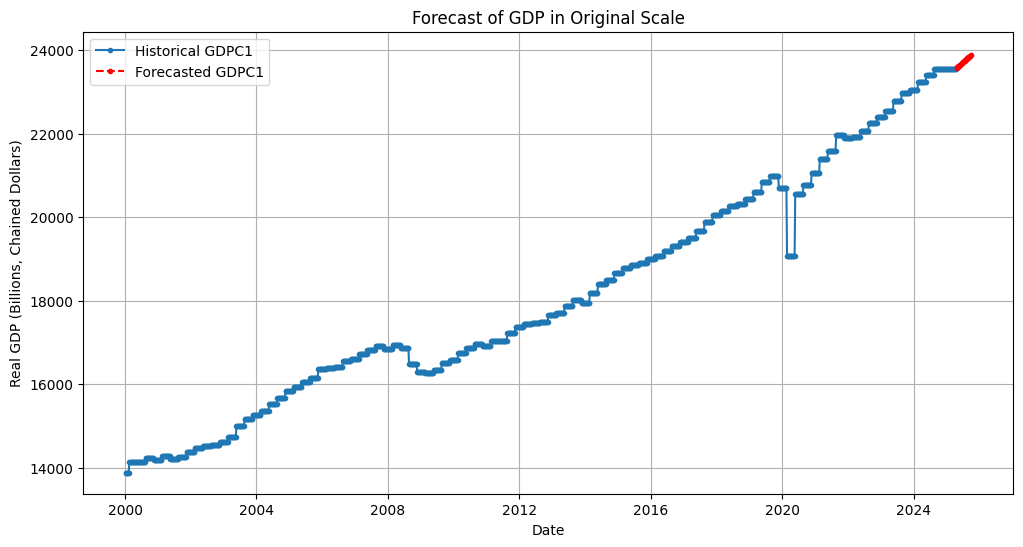

Forecasted GDP values (original scale):
2025-04-18    23566.89
2025-04-25    23582.22
2025-05-02    23596.64
2025-05-09    23610.61
2025-05-16    23624.35
2025-05-23    23637.97
2025-05-30    23651.54
2025-06-06    23665.08
2025-06-13    23678.61
2025-06-20    23692.13
2025-06-27    23705.64
2025-07-04    23719.15
2025-07-11    23732.67
2025-07-18    23746.18
2025-07-25    23759.69
2025-08-01    23773.20
2025-08-08    23786.72
2025-08-15    23800.23
2025-08-22    23813.74
2025-08-29    23827.25
2025-09-05    23840.76
2025-09-12    23854.28
2025-09-19    23867.79
2025-09-26    23881.30
Freq: W-FRI, dtype: float64


In [6]:
# =============================================================================
# SECTION 6: FORECASTING ACTUAL GDP VALUES
# =============================================================================
h = 24  # forecast horizon (weeks)
# Forecast observed standardized data using the state-space model's forecasting method.
try:
    forecast_obj = final_res.get_forecast(steps=h)
    X_forecast_std = forecast_obj.predicted_mean  # shape (h, N_total)
    print("State-space forecast obtained via get_forecast().")
except Exception as e:
    print(f"get_forecast() failed: {e}")
    # Fallback forecast using a simple VAR(2) on latent factors:
    q = final_Lambda.shape[1]
    A1 = np.full((q,), 0.5)
    A2 = np.full((q,), 0.2)
    F_forecast = np.zeros((q, h))
    F_forecast[:, 0] = F_final[:, -1]
    if h > 1:
        F_forecast[:, 1] = F_final[:, -2]
    for t in range(2, h):
        F_forecast[:, t] = A1 * F_forecast[:, t-1] + A2 * F_forecast[:, t-2] + np.random.normal(0, 0.1, q)
    X_forecast_std = (final_Lambda @ F_forecast).T
    print("Forecast computed manually via VAR(2) projection on latent factors.")

# Identify the column for GDPC1 in the standardized data (data_std)
gdp_idx = list(data_std.columns).index("GDPC1")
gdp_forecast_std = X_forecast_std[:, gdp_idx]

# --- UNSTANDARDIZE GDP ---
# IMPORTANT: Use the raw (unstandardized) data to compute the mean and std.
gdp_raw = raw_merged_data["GDPC1"].dropna()
gdp_mean = gdp_raw.mean()
gdp_std = gdp_raw.std()
gdp_forecast_actual = gdp_forecast_std * gdp_std + gdp_mean

forecast_index = pd.date_range(raw_merged_data.index[-1] + pd.DateOffset(weeks=1), periods=h, freq="W-FRI")
plt.figure(figsize=(12, 6))
plt.plot(gdp_raw.index, gdp_raw, label="Historical GDPC1", marker="o", markersize=3, linestyle="-")
plt.plot(forecast_index, gdp_forecast_actual, label="Forecasted GDPC1", color="red", marker="o", markersize=3, linestyle="--")
plt.fill_between(forecast_index,
                 gdp_forecast_actual - 0.02 * gdp_std,
                 gdp_forecast_actual + 0.02 * gdp_std,
                 color="red", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Real GDP (Billions, Chained Dollars)")
plt.title("Forecast of GDP in Original Scale")
plt.legend()
plt.grid(True)
plt.show()

print("Forecasted GDP values (original scale):")
print(pd.Series(gdp_forecast_actual, index=forecast_index).round(2))

In [7]:
raw_merged_data.GDPC1

2000-01-07    13878.147
2000-01-14    13878.147
2000-01-21    13878.147
2000-01-28    13878.147
2000-02-04    13878.147
                ...    
2025-03-14    23542.349
2025-03-21    23542.349
2025-03-28    23542.349
2025-04-04    23542.349
2025-04-11    23542.349
Freq: W-FRI, Name: GDPC1, Length: 1319, dtype: float64

🔎 Model Fit on Historical GDP:
RMSE: 0.01
MAE : 0.00
R²   : 0.9999


/Users/alexbactat/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/fb/bg4mg9bn5292qmdwf9bl_8tc0000gn/T/ipykernel_69146/3272799513.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/alexbactat/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


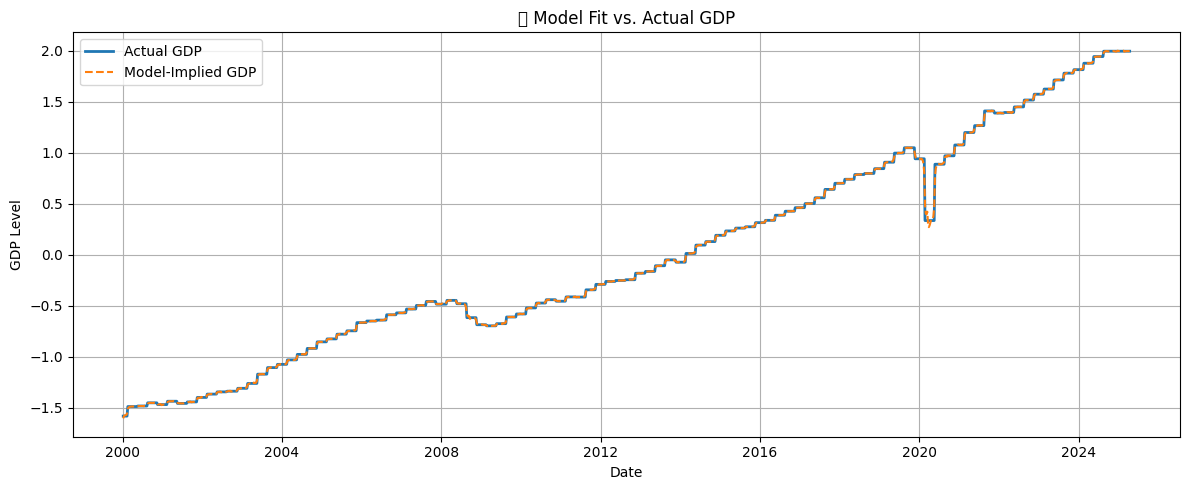

In [8]:
# =============================================================================
# EVALUATE MODEL ACCURACY ON HISTORICAL GDP
# =============================================================================

# --- Step 1: Extract smoothed trend and factors ---
trend_est = smoothed_states[0, :]            # g_t (trend)
F_final = smoothed_states[1:1 + q, :]        # f_t (cycle factors), shape: (q, T)

# --- Step 2: Reconstruct standardized GDP from model ---
gdp_series_name = "GDPC1"
idx_gdp = list(data_std.columns).index(gdp_series_name)
gdp_loadings = final_Lambda[idx_gdp, :]      # GDPC1's factor loadings, shape: (q,)

# Forecast standardized GDP: ŷ = g_t + Λ * f_t
gdp_pred_std = trend_est + gdp_loadings @ F_final

# --- Step 3: Rescale to real GDP units ---
gdp_raw = merged_data[gdp_series_name].dropna()
raw_mean = gdp_raw.mean()
raw_std = gdp_raw.std()

# Align forecast length to actual GDP
gdp_pred_std = gdp_pred_std[:len(gdp_raw)]
gdp_pred = gdp_pred_std * raw_std + raw_mean

# --- Step 4: Accuracy Metrics ---
actual = gdp_raw.values
predicted = gdp_pred

rmse = mean_squared_error(actual, predicted, squared=False)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

print("🔎 Model Fit on Historical GDP:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²   : {r2:.4f}")

# --- Step 5: Plot Actual vs. Fitted GDP ---
plt.figure(figsize=(12, 5))
plt.plot(gdp_raw.index, actual, label="Actual GDP", linewidth=2)
plt.plot(gdp_raw.index, predicted, label="Model-Implied GDP", linestyle='--')
plt.title("📈 Model Fit vs. Actual GDP")
plt.xlabel("Date")
plt.ylabel("GDP Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()